<a href="https://colab.research.google.com/github/Habonit/sparta_coding_ai/blob/main/week7_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week7_basic

- 1) Next Token Prediction 수행하기

- 2) 기본 과제는, 딱 기본적인, next token prediction 코드를 수행해보고 구조를 이해하는 것으로 한정하여 과제를 진행할 예정입니다.

- 3) 단, 모델은 llama 3.1 1b를 튜닝해볼 예정입니다. 이는 llama를 최종 프로젝트에 사용할 예정이기 때문에 모델 사용법을 숙지하고자 하기 위함입니다.

In [ ]:
!pip install -q datasets

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import wandb

wandb.login()

# Preprocess

In [ ]:
import os
import sys
import torch
import logging
import datasets
import transformers
import wandb

from itertools import chain
from dataclasses import dataclass, field
from typing import Optional
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    default_data_collator
)
from transformers.trainer_utils import get_last_checkpoint

# Data Load

- 1) wiki 데이터를 가져와 토크나이저로 인코딩을 합니다

- 2) train: val: test = 0.7 : 0.2 : 0.1

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

wandb.init(project='LLaMA-Finetuning')
wandb.run.name = 'llama-1B-next-token-prediction'

model_name = "meta-llama/Llama-3.2-1B"
dataset_name = "wikitext"
dataset_config_name = "wikitext-103-v1"
torch_dtype = "bfloat16"
block_size = 1024
num_workers = 4

raw_datasets = load_dataset(dataset_name, dataset_config_name)
sample_frac = 0.01
small_dataset = raw_datasets["train"].shuffle(seed=42).select(range(int(len(raw_datasets["train"]) * sample_frac)))
split_dataset = small_dataset.train_test_split(test_size=0.1)
dataset = split_dataset["train"]

config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
    torch_dtype=torch.bfloat16 if torch_dtype == "bfloat16" else torch.float16
)

tokenizer.pad_token_id = tokenizer.eos_token_id

tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    num_proc=num_workers,
    remove_columns=raw_datasets["train"].column_names
)


In [ ]:
def group_texts(examples):
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size

    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }

    result["labels"] = result["input_ids"].copy()
    return result

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=num_workers
)

dataset = lm_datasets["train"]
train_dataset = dataset.select(range(70))
val_dataset = dataset.select(range(70,90))
test_dataset = dataset.select(range(90,100))


In [ ]:
train_dataset

In [ ]:
val_dataset

In [ ]:
test_dataset

# Training Args

In [ ]:
training_args = TrainingArguments(
    output_dir="./llama-finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=10,
    save_total_limit=2,
    logging_dir="./logs",
    report_to="wandb"   ,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # 검증 데이터셋 추가
    tokenizer=tokenizer,
    data_collator=default_data_collator
)

# Metric Comparision

In [ ]:
initial_results = trainer.evaluate(test_dataset)
initial_results

In [ ]:
trainer.train()

https://wandb.ai/khk172216/LLaMA-Finetuning/runs/ejnk6bld/panel/5qsd2txxh?nw=nwuserkhk172216

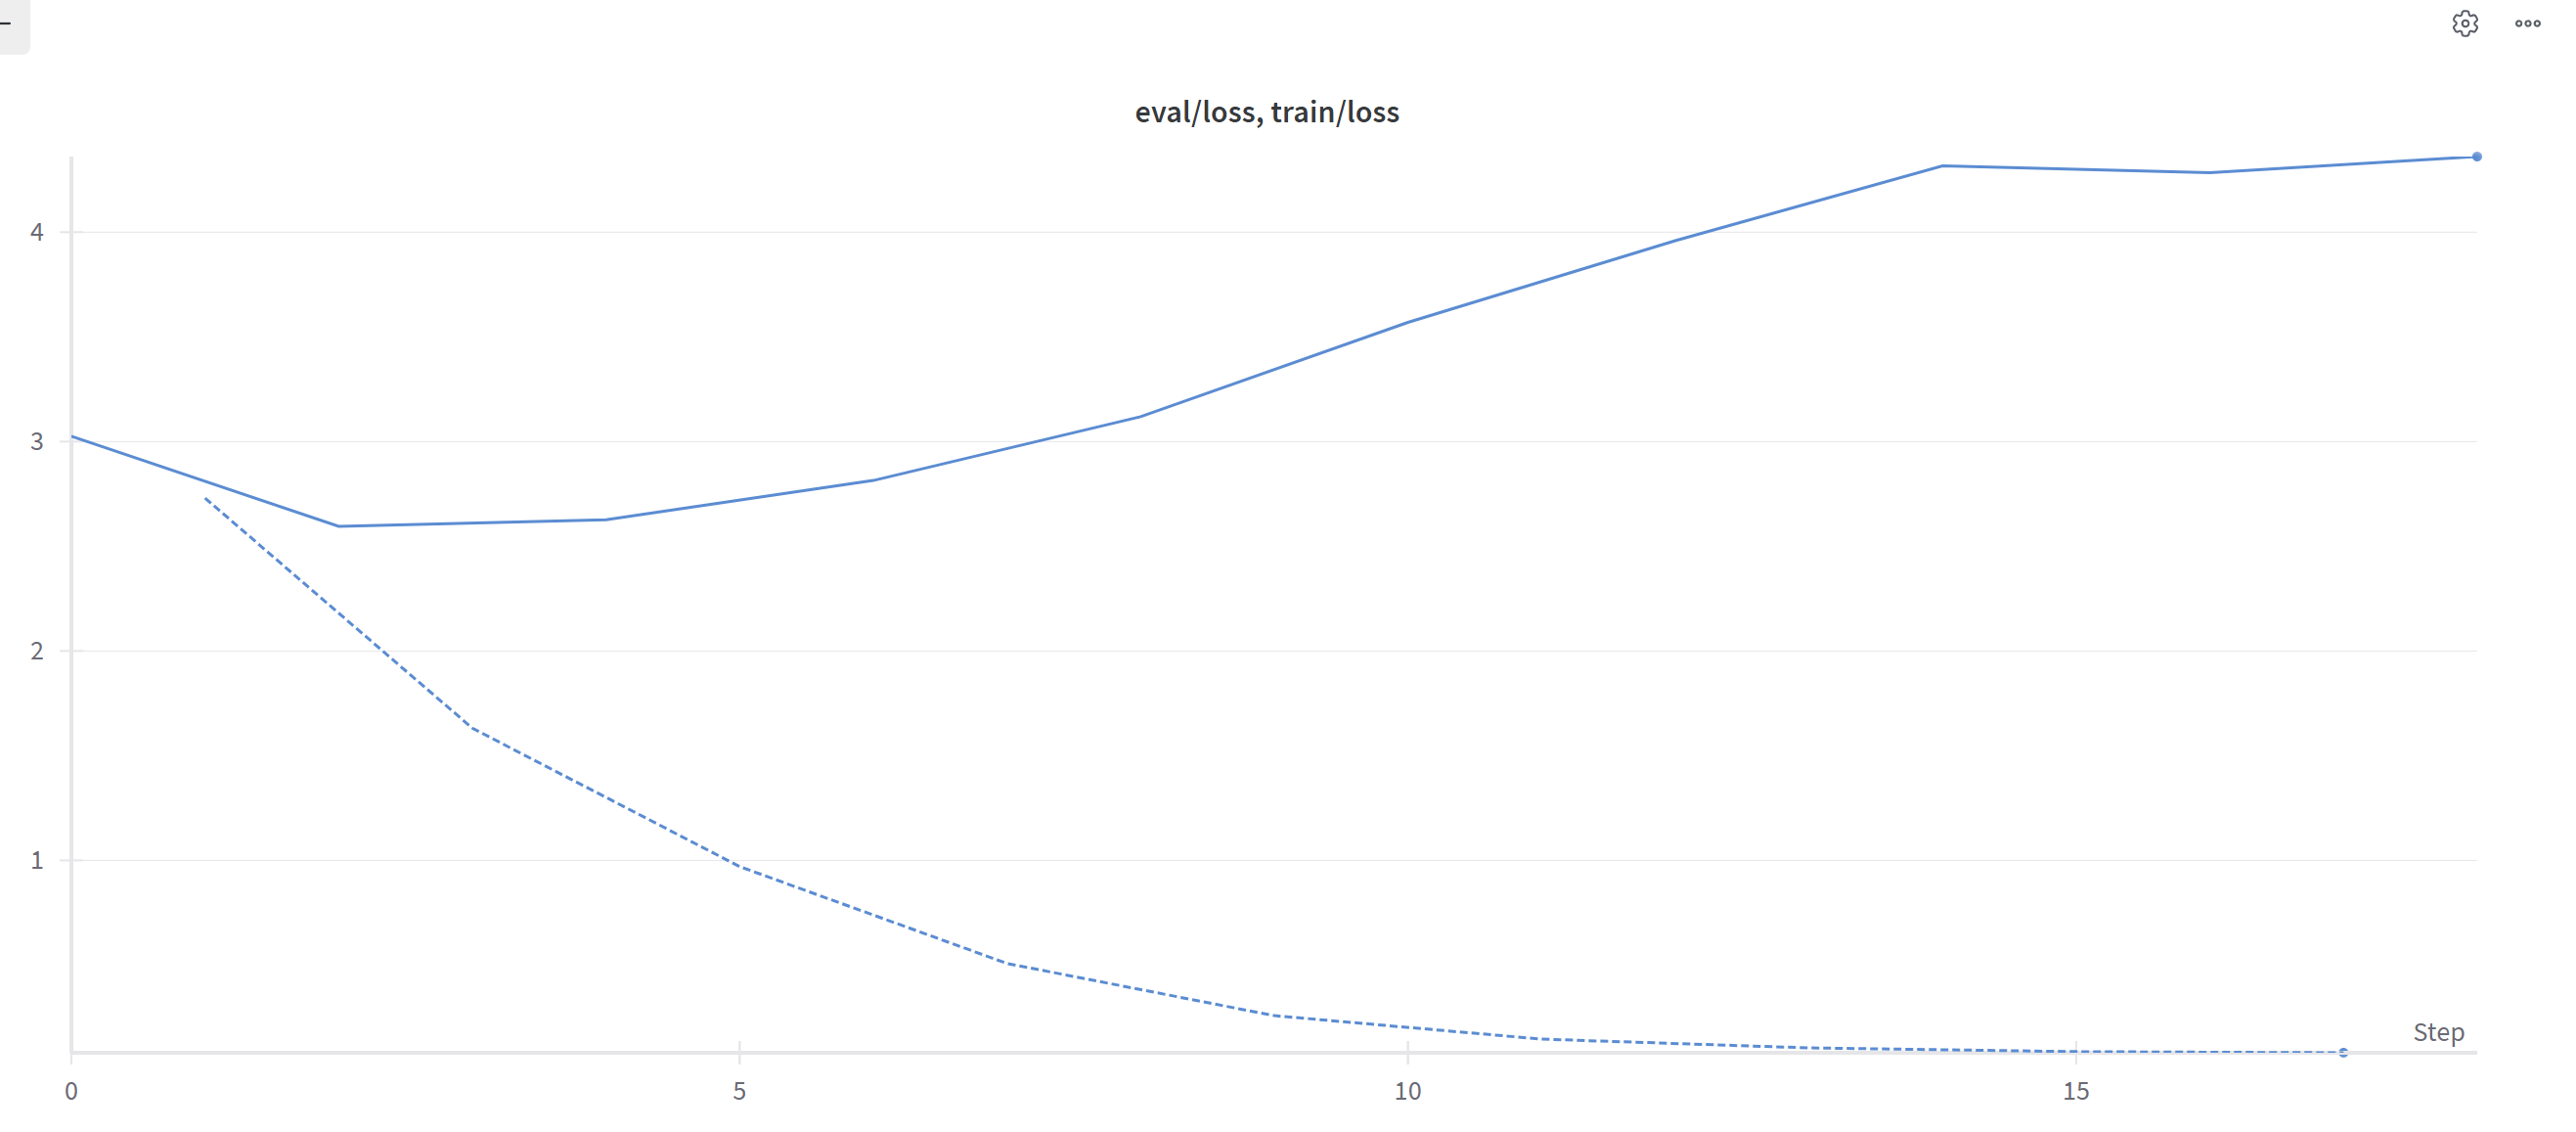

In [ ]:
trained_results = trainer.evaluate(test_dataset)
trained_results

# Conclusion

- 1) 1에폭만에 오버피팅이 발생하는 것을 확인하였습니다.

- 2) next token prediction 방식으로 훈련을 할거면 정말 많은 양의 데이터를 학습시켜야 하는데, 지금은 100개 샘플만 가지고 훈련을 하다보니 일어난 결과라고 예측하고 있습니다.

- 3) 훈련 자체가 효과가 있었음은 확인하였습니다.